# Network analysis

In [0]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import community
import math


# Supress scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [0]:
# Load edge and vertex data
edges = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/network-data/edges.csv')
vertices = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/network-data/vertices.csv', encoding='utf-8', engine='c')

# Id set
idSet = set(vertices['id'])

# Dictionary to relabel nodes
mapping = {}
for index, row in vertices.iterrows():
  id = int(row['id'])
  screen_name = row['screen_name']
  mapping[id]=screen_name

## Creating the network

In [0]:
# Create graph object
G = nx.DiGraph()
UG = nx.Graph()

for n in range(len(vertices)):
    node = vertices["id"][n]

    # Add nodes
    G.add_node(node)
    UG.add_node(node)

    # Add attributes
    G.nodes[node]["ScreenName"] = vertices["screen_name"][n]
    G.nodes[node]["Followers"] = vertices["followers"][n]
    UG.nodes[node]["ScreenName"] = vertices["screen_name"][n]
    UG.nodes[node]["Followers"] = vertices["followers"][n]
    
for e in range(len(edges)):
    n1 = int(edges["source"][e])
    n2 = int(edges["target"][e])
    
    if n1 in idSet and n2 in idSet and not G.has_edge(n1, n2):
        G.add_edge(n1, n2, weight=1)
    if n1 in idSet and n2 in idSet and not UG.has_edge(n1, n2):
        UG.add_edge(n1, n2, weight=1)
        

In [0]:
# Import tweets
tweets = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/tweets/statuses.csv')

In [0]:
# Increase weights to graph based on mentions
for index, row in tweets.iterrows():
    author_id = int(row['id'])
    mentions = row['mentions'][1:len(row['mentions'])-1].split(', ')
    for m in mentions:
        if m:
            mentioned_id = int(m)
            if author_id in idSet and mentioned_id in idSet and G.has_edge(author_id, mentioned_id):
                # Increase weight by 1 for every mention
                G[author_id][mentioned_id]['weight'] = G[author_id][mentioned_id]['weight']+1
                
            if author_id in idSet and mentioned_id in idSet and UG.has_edge(author_id, mentioned_id):
                # Increase weight by 1 for every mention
                UG[author_id][mentioned_id]['weight'] = UG[author_id][mentioned_id]['weight']+1
                
# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))
UG.remove_nodes_from(list(nx.isolates(UG)))

In [0]:
# Export graphml file
nx.write_graphml(G, "network.graphml")

# Relabel nodes with screen name
G2 = nx.relabel_nodes(UG, mapping)

# Export graphml file
nx.write_graphml(G2, "network_screen_names.graphml")

[G.number_of_nodes(), G.number_of_edges()]

[1789, 44576]

## Network characterization

In [0]:
# Densidad
print(nx.density(G))

# Clustering promedio
print(nx.average_clustering(G))

# Transitividad
print(nx.transitivity(G))

0.013935521950572915
0.046195571542618205
0.040399530093311216


## Communities

In [0]:
# Find communities using the Louvain method
partition = community.best_partition(G2, random_state=0)

In [0]:
top_users = [] 
for p in range(0,9):
  firstId = firstF = secondId = secondF = -1
  for k in partition:
    if partition[k]==p:
      if G2.nodes[k]['Followers'] > firstF:
        secondId = firstId
        secondF = firstF
        firstId = k
        firstF = G2.nodes[k]['Followers']
      elif G2.nodes[k]['Followers'] > secondF:
        secondId = k
        secondF = G2.nodes[k]['Followers']
  top_users.extend([firstId, secondId])

print(top_users)

['cejaspobladas', '_ELBRAYAN_', 'JuanManSantos', 'elespectador', 'AlvaroUribeVel', 'WRadioColombia', 'ELTIEMPO', 'CaracolTV', 'newsCaracol', 'elpaiscali', 'jamesdrodriguez', 'FALCAO', 'newsRCN', 'lafm', 'Teleantioquia', 'AlfredoRamosM', 'SamsungCO', 'GuilloEscalante']


In [0]:
# pygraphviz
!wget https://anaconda.org/anaconda/pygraphviz/1.3/download/linux-64/pygraphviz-1.3-py36h14c3975_1.tar.bz2
!tar xvjf pygraphviz-1.3-py36h14c3975_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/

!pip install pygraphviz

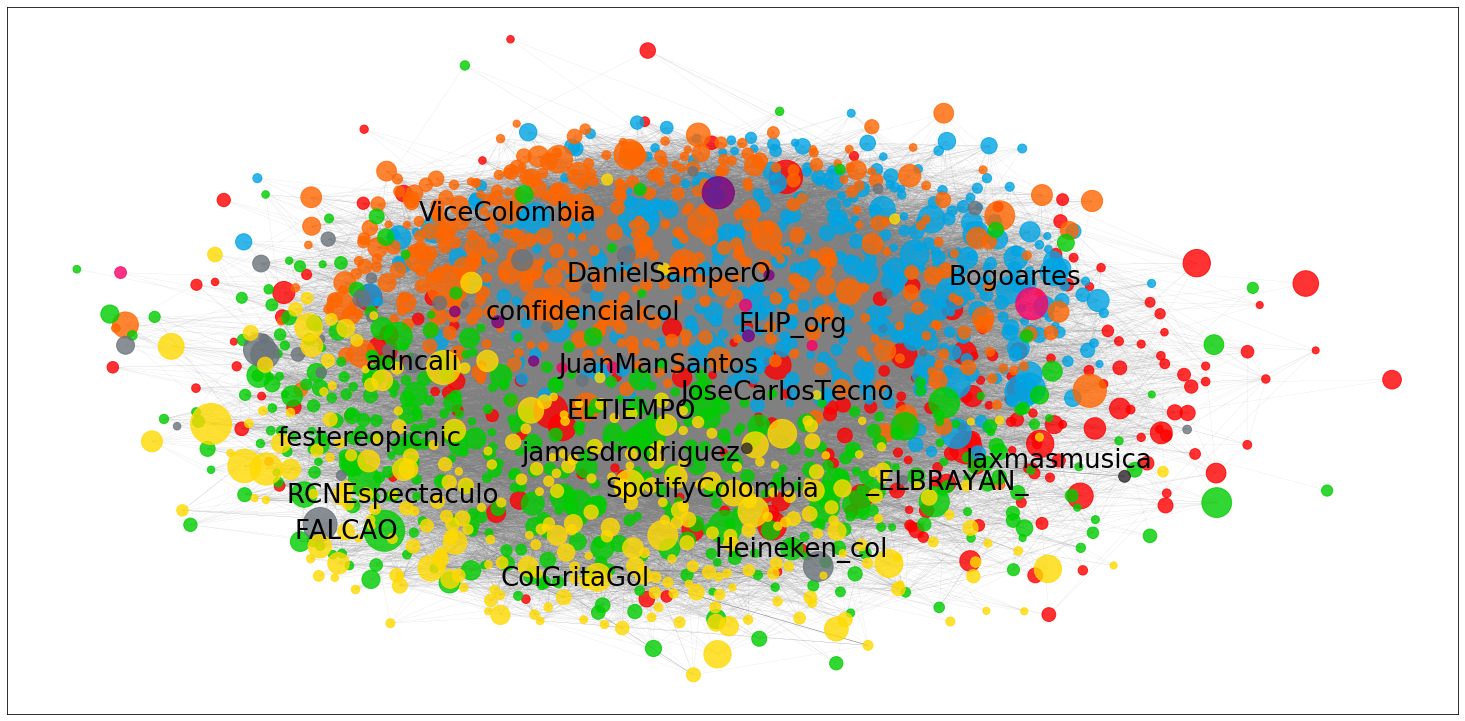

In [0]:
# Draw the network
pos = nx.nx_agraph.graphviz_layout(G2, prog='neato')


fig = plt.figure(figsize=(26,13))

colors = ["#FF0000","#00A4E4","#FF6600","#00cd00","#6A737B","#FFDA00","#FF0065","#800080","#2E282A"
        ]

for p in range(0,9):
  nx.draw_networkx_nodes(G2, pos, 
                       nodelist = [g for g in G2.nodes() if partition[g] == p ],
                       node_size = [math.sqrt(G2.nodes[g]['Followers'])*0.4 for g in G2.nodes()],
                       node_color = colors[p],
                       alpha=0.8)

users = ['_ELBRAYAN_', 'JuanManSantos', 'ViceColombia', 'laxmasmusica', 'festereopicnic', 'FLIP_org', 'adncali', 'JoseCarlosTecno', 'ELTIEMPO', 'SpotifyColombia', 'RCNEspectaculo', 'Heineken_col', 'confidencialcol', 'ColGritaGol', 'DanielSamperO', 'jamesdrodriguez', 'FALCAO', 'Bogoartes']

nx.draw_networkx_labels(G2, pos, font_size=26, font_color='black', labels = {x:x for x in G2.nodes() if x in users})


nx.draw_networkx_edges(G2, pos, edge_color='grey', width=[math.sqrt(G2[u][v]['weight'])/15 for u,v in G2.edges()])

In [0]:
# Create data frame with community info
partition_df = pd.DataFrame.from_dict(list(partition.items()))
partition_df.columns = ['id', 'partition']
partition_df.head()

,id,partition
0,11545,0
1,782076,1
2,3376511,1
3,6003222,2
4,7641802,2


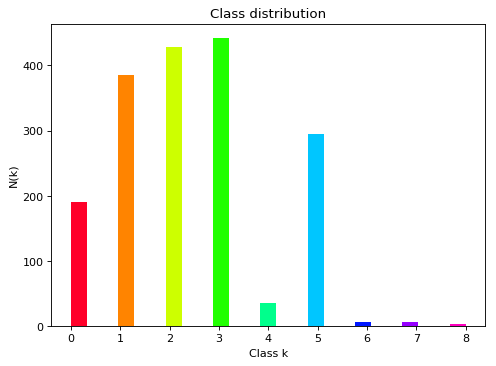

In [0]:
from matplotlib import colors

plt.figure(num=None, figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
partitions = [list(partition_df['partition'])]

cm = plt.get_cmap('gist_rainbow')

# Plot histogram.
n, bins, patches = plt.hist(partitions, bins='auto')

# scale values to interval [0,1]
col = np.arange(0,len(partition_df['partition'].unique())+15.1)
col = col / max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.title('Class distribution')
plt.xlabel('Class k')
plt.ylabel('N(k)')
plt.show()

## Core

In [0]:
cores = nx.core_number(G)

# Create data frame with core number info
core_df = pd.DataFrame.from_dict(list(cores.items()))
core_df.columns = ['id', 'core']
core_df.head()

,id,core
0,11545,31
1,782076,31
2,3376511,31
3,6003222,31
4,7641802,31


In [0]:
print(len(partition_df),len(core_df))
# Merge partition and core info in dataframe
user_info = pd.merge(partition_df, core_df, on='id')
print(len(user_info))
user_info.head()

1789 1789
1789


,id,partition,core
0,11545,0,31
1,782076,1,31
2,3376511,1,31
3,6003222,2,31
4,7641802,2,31


## Node influence

In [0]:
# Find vote rank for every node
vote_rank = nx.voterank(UG)
voterank_dict = {}

for rank in range(len(vote_rank)):
  score = 1 / (rank+1)
  voterank_dict[vote_rank[rank]] = score
    
for n in G.nodes():
  if not n in voterank_dict:
    voterank_dict[n] = 0

In [0]:
''' Network measures '''

in_degree = G.in_degree()
clustering = nx.clustering(G)
h,a = nx.hits(G, normalized=False)
between_centrality = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G)
pr = nx.pagerank(G, weight='weight')

# Create user dataset
user_data = []
for n,d in G.nodes(data=True):
    user_data.append([n, in_degree[n], clustering[n], closeness[n],
                      between_centrality[n], voterank_dict[n],a[n], h[n], pr[n]])

user = pd.DataFrame(user_data)
user.columns=['id', 'in_degree', 'clustering', 'closeness', 'betweenness', 'vote_rank', 'authority', 'hubs', 'pagerank']
user["id"] = pd.to_numeric(user["id"])

user.head()

,id,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank
0,11545,30,0.07,0.37,0.00,0.00,0.00,0.00,0.00
1,782076,33,0.05,0.38,0.00,0.00,0.00,0.00,0.00
2,3376511,66,0.03,0.42,0.01,0.01,0.01,0.00,0.00
3,6003222,47,0.03,0.39,0.00,0.00,0.00,0.01,0.00
4,7641802,11,0.02,0.33,0.00,0.00,0.00,0.00,0.00


In [0]:
from collections import defaultdict

# Dictionary to store total out degree from a cluster to all other clusters:
# class -> sum of edges from this class to other classes
sum_external = defaultdict(lambda: 0)

# Dictionary to store maximum degree within clusters: partition -> max degree
max_internal = defaultdict(lambda: 0)

# Create dictionary with in degree from other clusters to a node
# (node,class)-> in degree of node with edges from class
external_degree = defaultdict(lambda: 0)

# Create dictionary with node degree within the cluster
internal_degree = defaultdict(lambda: 0)

# Traverse all edges from an origin node (o) and a destination node (d)
for o in G.nodes():
  for d in G.neighbors(o):
    
    # Nodes belong to the same partition
    if partition[o] == partition[d]:
      # Increase internal degree count for node d
      internal_degree[d] = internal_degree[d] + 1
      
      # Update maximum 
      if max_internal[partition[d]] < internal_degree[d]:
        max_internal[partition[d]] = internal_degree[d]
      
    # Nodes belong to different partitions
    else: 
      # Increase value in external degree dictionary
      key = (d,partition[d])
      # Key is already in dictionary
      if key in external_degree:
        external_degree[key] = external_degree[key] + 1
      # Add key to dictionary
      else: 
        external_degree[key] = 1
      
      # Update sum 
      sum_external[partition[o]] = sum_external[partition[o]] + 1
     

In [0]:
# Get partition sizes
partition_counts = partition_df.groupby('partition').count()

In [0]:
# Find ambassador nodes: Nodes with higher in degree from an external community to their communities are more ambassadors.
# Nodes that are connected to large communities are more important ambassadors
ambassadors = {}
max_ambassador = 0
# Take into account size of other community
for n in G.nodes():
  score = 0
  for p in range(8):
    key = (n,p)
    partition_score = partition_counts.loc[p].id * external_degree[key] / sum_external[p]
    score += partition_score
  ambassadors[n] = score
  if score > max_ambassador:
    max_ambassador = score
    
for n in G.nodes():
  ambassadors[n] = ambassadors[n] / max_ambassador

# Find community hubs: Nodes with higher in degree within their communities are better community hubs.
# Nodes that are connected to large communities are more important ambassadors
community_hubs = {}
max_ch = 0

for n in G.nodes():
  score = partition_counts.loc[partition[n]].id * internal_degree[n] / max_internal[partition[n]]
  community_hubs[n] = score
  if score > max_ch:
    max_ch = score
    
for n in G.nodes():
  community_hubs[n] = community_hubs[n] / max_ch

In [0]:
# Create ambassador and community hub dataset
a_ch_dataset = []
for n in G.nodes():
    a_ch_dataset.append([n, ambassadors[n], community_hubs[n]])

a_ch_df = pd.DataFrame(a_ch_dataset)
a_ch_df.columns=['id', 'ambassador', 'community_hub']
a_ch_df.head()

,id,ambassador,community_hub
0,11545,0.06,0.18
1,782076,0.05,0.27
2,3376511,0.15,0.42
3,6003222,0.19,0.10
4,7641802,0.02,0.05


In [0]:
print(len(user), len(user_info), len(a_ch_df))
# Merge partition, core, ambassador and community hub info in dataframe
user_info = pd.merge(user_info, user, on='id')
user_info = pd.merge(user_info, a_ch_df, on='id')
print(len(user_info))
user_info.head()

1789 1789 1789
1789


,id,partition,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub
0,11545,0,31,30,0.07,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.18
1,782076,1,31,33,0.05,0.38,0.00,0.00,0.00,0.00,0.00,0.05,0.27
2,3376511,1,31,66,0.03,0.42,0.01,0.01,0.01,0.00,0.00,0.15,0.42
3,6003222,2,31,47,0.03,0.39,0.00,0.00,0.00,0.01,0.00,0.19,0.10
4,7641802,2,31,11,0.02,0.33,0.00,0.00,0.00,0.00,0.00,0.02,0.05


In [0]:
# Merge user info and vertices info
user_info = pd.merge(user_info, vertices, on='id')
print(len(user_info))
user_info.head()

1789


,id,partition,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub,screen_name,followers,friends,verified,description,created_at,listed,tipo
0,11545,0,31,30,0.07,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.18,diegocambiaso,120333,4045,True,Desarrollador de software comunicador social ...,2006,669,personal
1,782076,1,31,33,0.05,0.38,0.00,0.00,0.00,0.00,0.00,0.05,0.27,Caidadelatorre,77081,299,True,Columnista de @ElTiempo. Occasional collaborat...,2007,505,personal
2,3376511,1,31,66,0.03,0.42,0.01,0.01,0.01,0.00,0.00,0.15,0.42,JuanPabloCalvas,64227,5443,False,/ periodista / lector / no voy en avión voy e...,2007,400,journalism
3,6003222,2,31,47,0.03,0.39,0.00,0.00,0.00,0.01,0.00,0.19,0.10,Solano,66092,3065,True,Periodista. Consultor en reputación #Transfor...,2007,1574,journalism
4,7641802,2,31,11,0.02,0.33,0.00,0.00,0.00,0.00,0.00,0.02,0.05,noticucuta,133474,729,False,NaN,2007,437,news


In [0]:
user_info.to_csv('user_info.csv', index=False)

In [0]:
# Remove unnecessary columns from tweets dataset
tweets = tweets.drop(['text','phone','hashtags','mentions'], axis=1)
tweets.head()

KeyError: ignored

In [0]:
# Change created at time with categorical time of the day
for i, row in tweets.iterrows():
  created = row['created_at']
  time = int(created.split(' ')[1].split(':')[0])
  
  if time > 12 and time < 19:
    tweets.at[i,'created_at'] = 'afternoon'
  elif time <=12 and time >=11:
    tweets.at[i,'created_at'] = 'noon'
  elif time <11 and time >5:
    tweets.at[i,'created_at'] = 'morning'
  elif time<=5 and time > 0:
    tweets.at[i,'created_at'] = 'early morning'
  elif time==0 or time>21:
    tweets.at[i,'created_at'] = 'late night'
  elif time>=19 and time <=21:
    tweets.at[i,'created_at'] = 'night'

In [0]:
print(len(tweets))
tweets.head(n=10)

203168


,id,tweet_id,created_at,favorite_count,retweet_count,sensitive,no_hashtags,no_mentions,no_urls,no_media
0,113127283,1172524340002390000,afternoon,1,0,False,0,6,0,1
1,113127283,1172523885654350000,afternoon,2,0,False,0,5,0,1
2,113127283,1172523505537170000,afternoon,1,0,False,0,6,0,1
3,113127283,1172522933601880000,afternoon,0,0,False,0,6,0,1
4,113127283,1172522449184960000,afternoon,0,0,False,0,4,0,1
5,113127283,1172521898636450000,afternoon,1,0,False,0,6,0,1
6,113127283,1172521471215840000,afternoon,0,0,False,0,4,0,1
7,113127283,1172520154200200000,afternoon,0,0,False,0,5,0,1
8,113127283,1172518323977880000,afternoon,0,0,False,0,5,0,1
9,113127283,1172517146557130000,afternoon,0,1,False,0,5,0,1


In [0]:
# Import sentiment analysis results
sentiment_results = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/analysis_results.csv')
len(sentiment_results)

201785

In [0]:
# Merge tweet info and sentiment analysis info
tweet_data = pd.merge(tweets, sentiment_results, how='right', on='tweet_id')
tweet_data = tweet_data.drop(['id_y'], axis=1)
tweet_data = tweet_data.rename(columns={"id_x": "id"})
print(len(tweet_data))
tweet_data.head()

201785


,id,tweet_id,created_at,favorite_count,retweet_count,sensitive,no_hashtags,no_mentions,no_urls,no_media,engagement,effective_length,polarity,subjectivity,average_engagement,common_words,common_ht_words,common_hts
0,113127283,1172524340002390000,afternoon,1,0,False,0,6,0,1,1,103,0.52,0.59,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),..."
1,113127283,1172523885654350000,afternoon,2,0,False,0,5,0,1,2,262,0.04,0.28,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),..."
2,113127283,1172523505537170000,afternoon,1,0,False,0,6,0,1,1,191,0.00,0.00,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),..."
3,113127283,1172522933601880000,afternoon,0,0,False,0,6,0,1,0,136,0.00,0.00,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),..."
4,113127283,1172522449184960000,afternoon,0,0,False,0,4,0,1,0,273,0.10,0.45,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),..."


In [0]:
user_info = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/network-data/user_info.csv')
user_info.head()

,id,partition,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub,screen_name,followers,friends,verified,description,created_at,listed,tipo
0,11545,0,31,30,0.07,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.18,diegocambiaso,120333,4045,True,Desarrollador de software comunicador social ...,2006,669,personal
1,782076,1,31,33,0.05,0.38,0.00,0.00,0.00,0.00,0.00,0.05,0.27,Caidadelatorre,77081,299,True,Columnista de @ElTiempo. Occasional collaborat...,2007,505,personal
2,3376511,1,31,66,0.03,0.42,0.01,0.01,0.01,0.00,0.00,0.15,0.42,JuanPabloCalvas,64227,5443,False,/ periodista / lector / no voy en avión voy e...,2007,400,journalism
3,6003222,2,31,47,0.03,0.39,0.00,0.00,0.00,0.01,0.00,0.19,0.10,Solano,66092,3065,True,Periodista. Consultor en reputación #Transfor...,2007,1574,journalism
4,7641802,2,31,11,0.02,0.33,0.00,0.00,0.00,0.00,0.00,0.02,0.05,noticucuta,133474,729,False,NaN,2007,437,news


In [0]:
# Merge tweet data with user info
dataset = pd.merge(tweet_data, user_info, on='id')
dataset = dataset.rename(columns={"created_at_x": "created_at_tweet", "created_at_y":"created_at_account"})
print(len(dataset))
dataset.head()

194171


,id,tweet_id,created_at_tweet,favorite_count,retweet_count,sensitive,no_hashtags,no_mentions,no_urls,no_media,engagement,effective_length,polarity,subjectivity,average_engagement,common_words,common_ht_words,common_hts,partition,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub,screen_name,followers,friends,verified,description,created_at_account,listed,tipo
0,113127283,1172524340002390000,afternoon,1,0,False,0,6,0,1,1,103,0.52,0.59,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),...",2,31,28,0.03,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.12,ArchivoGeneral,26830,1062,True,Custodiamos protegemos y ponemos al servicio ...,2010,328,informative
1,113127283,1172523885654350000,afternoon,2,0,False,0,5,0,1,2,262,0.04,0.28,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),...",2,31,28,0.03,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.12,ArchivoGeneral,26830,1062,True,Custodiamos protegemos y ponemos al servicio ...,2010,328,informative
2,113127283,1172523505537170000,afternoon,1,0,False,0,6,0,1,1,191,0.00,0.00,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),...",2,31,28,0.03,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.12,ArchivoGeneral,26830,1062,True,Custodiamos protegemos y ponemos al servicio ...,2010,328,informative
3,113127283,1172522933601880000,afternoon,0,0,False,0,6,0,1,0,136,0.00,0.00,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),...",2,31,28,0.03,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.12,ArchivoGeneral,26830,1062,True,Custodiamos protegemos y ponemos al servicio ...,2010,328,informative
4,113127283,1172522449184960000,afternoon,0,0,False,0,4,0,1,0,273,0.10,0.45,4.54,"[('archivos', 48), ('memoria', 36), ('informac...","[('memoria', 27), ('archivos', 16), ('innovan'...","[('LosArchivosInnovan', 16), ('SITA2019', 14),...",2,31,28,0.03,0.37,0.00,0.00,0.00,0.00,0.00,0.06,0.12,ArchivoGeneral,26830,1062,True,Custodiamos protegemos y ponemos al servicio ...,2010,328,informative


In [0]:
# Write dataset to file
dataset.to_csv('dataset.csv', index=False)